<a href="https://colab.research.google.com/github/prachi735/EVA4.0/blob/master/session6/EVA4_S6_F1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils

# Transformations

In [0]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       #transforms.RandomAffine((-5.0,5.0),fillcolor=1),
                                       #transforms.RandomPerspective(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Load dataset

In [3]:
train = datasets.MNIST('./data', train=True, download=True,transform=train_transforms)
test = datasets.MNIST('./data', train=True, download=True,transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloaders: Test/Train dataset

In [4]:
SEED = 3

# is cuda available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4,pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, ** dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Basic Model

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 26 output_size = 24 receptive_field = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 24 output_size = 22 receptive_field = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 22 output_size = 11 receptive_field = 9
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 11 output_size = 11 receptive_field = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 11 output_size = 9 receptive_field = 13
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 9 output_size = 7 receptive_field = 17
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 7 output_size = 5 receptive_field = 21
        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
        ) # input_size = 5 output_size = 1  receptive_field = 29
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [6]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1

#Training & Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train & Test model

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11179938912391663 Batch_id=468 Accuracy=93.30: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 58745/60000 (97.91%)

EPOCH: 1


Loss=0.04570843651890755 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:20<00:00, 27.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 59225/60000 (98.71%)

EPOCH: 2


Loss=0.04758238419890404 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:20<00:00, 28.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 59332/60000 (98.89%)

EPOCH: 3


Loss=0.015284344553947449 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 59238/60000 (98.73%)

EPOCH: 4


Loss=0.011759698390960693 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 59381/60000 (98.97%)

EPOCH: 5


Loss=0.036482613533735275 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 59388/60000 (98.98%)

EPOCH: 6


Loss=0.11527281254529953 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:20<00:00, 28.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 59497/60000 (99.16%)

EPOCH: 7


Loss=0.05734805762767792 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 59472/60000 (99.12%)

EPOCH: 8


Loss=0.0600963719189167 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 59492/60000 (99.15%)

EPOCH: 9


Loss=0.0060336091555655 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 59555/60000 (99.26%)

EPOCH: 10


Loss=0.05330226197838783 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 59470/60000 (99.12%)

EPOCH: 11


Loss=0.11954817920923233 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 59421/60000 (99.03%)

EPOCH: 12


Loss=0.11359497904777527 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 59576/60000 (99.29%)

EPOCH: 13


Loss=0.05811356380581856 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:20<00:00, 28.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 59646/60000 (99.41%)

EPOCH: 14


Loss=0.059653669595718384 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 59643/60000 (99.41%)

EPOCH: 15


Loss=0.02292255125939846 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:20<00:00, 28.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 59672/60000 (99.45%)

EPOCH: 16


Loss=0.05591558292508125 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 59609/60000 (99.35%)

EPOCH: 17


Loss=0.3121993839740753 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 59567/60000 (99.28%)

EPOCH: 18


Loss=0.03962302580475807 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 59617/60000 (99.36%)

EPOCH: 19


Loss=0.03814821317791939 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 59628/60000 (99.38%)

EPOCH: 20


Loss=0.012007206678390503 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 59668/60000 (99.45%)

EPOCH: 21


Loss=0.03479619324207306 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 59635/60000 (99.39%)

EPOCH: 22


Loss=0.030817924067378044 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 59669/60000 (99.45%)

EPOCH: 23


Loss=0.013658334501087666 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 59670/60000 (99.45%)

EPOCH: 24


Loss=0.04112182930111885 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 59720/60000 (99.53%)

EPOCH: 25


Loss=0.023394649848341942 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 59662/60000 (99.44%)

EPOCH: 26


Loss=0.004610066767781973 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:21<00:00, 21.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 59686/60000 (99.48%)

EPOCH: 27


Loss=0.017119118943810463 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 59700/60000 (99.50%)

EPOCH: 28


Loss=0.016796061769127846 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:21<00:00, 21.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 59684/60000 (99.47%)

EPOCH: 29


Loss=0.009972895495593548 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 59695/60000 (99.49%)

EPOCH: 30


Loss=0.00902797281742096 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 59729/60000 (99.55%)

EPOCH: 31


Loss=0.01592065393924713 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 59696/60000 (99.49%)

EPOCH: 32


Loss=0.006589839700609446 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 59749/60000 (99.58%)

EPOCH: 33


Loss=0.024917637929320335 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:21<00:00, 26.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 59752/60000 (99.59%)

EPOCH: 34


Loss=0.01308631431311369 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 59669/60000 (99.45%)

EPOCH: 35


Loss=0.002522597787901759 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 59752/60000 (99.59%)

EPOCH: 36


Loss=0.08718281984329224 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 59779/60000 (99.63%)

EPOCH: 37


Loss=0.056635916233062744 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 59743/60000 (99.57%)

EPOCH: 38


Loss=0.007542923092842102 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:21<00:00, 26.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 59689/60000 (99.48%)

EPOCH: 39


Loss=0.08117857575416565 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 26.76it/s]



Test set: Average loss: 0.0120, Accuracy: 59778/60000 (99.63%)



# Ploting model result

Text(0.5, 1.0, 'Test Accuracy')

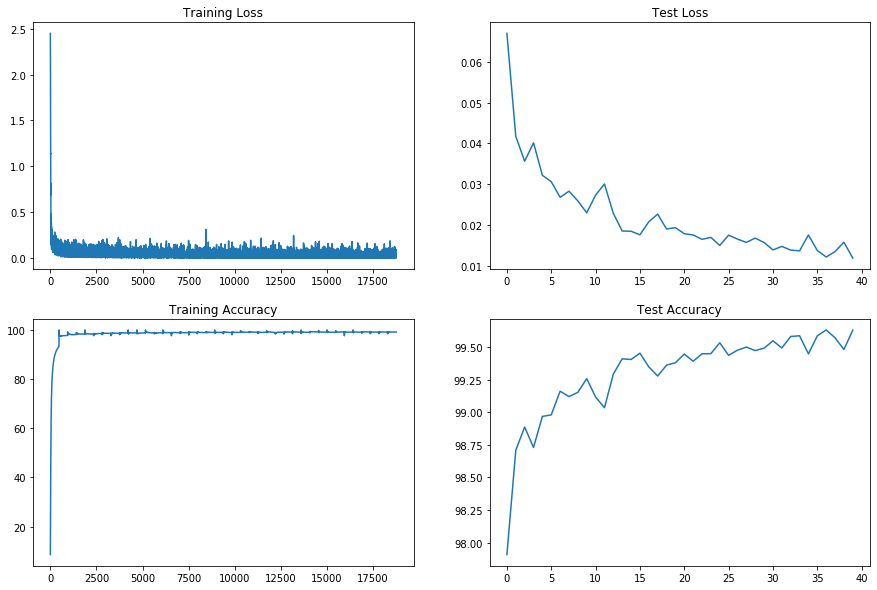

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")